In [167]:
import numpy as np
import math as math

# physical constants in cgs units
# obtained from https://www.physics.rutgers.edu/~abrooks/342/constants.html
c = 29979245800 # cm/s
h = 6.62507015 / (10**27) # cm^2 g s^-1
k_B = 1.380649 / (10**16) # cm^2 g s^-2 K^-1
R_sun = 6.96 * (10**10) # cm
pc = 3.08567758 * (10**18) # cm

def abs_coeff_r(T, nu, n_0, r):
    """calculates the absorption coefficient alpha_nu that is dependent on r through the relation n = n_0*r^-2.
    For fully ionized hydrogen, n_e = n_i & Z=1
    T = temperature
    nu = frequency
    n_0 = initial number density profile
    r = distance to absorption (from observer?) => variable
    """
    C = 3.692 * (10**8)  # the  number in front of the expression
    BB = 1 - np.exp(-(h * nu) / (k_B * T))  # term found in the blackbody spectrum
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )  # Gaunt factor
    return (C * BB * g * (n_0**2)) / (np.sqrt(T) * (nu**3) * 4 * (r**4))

def abs_coeff_n(T, nu, n):
    """calculates the absorption coefficient alpha_nu that is dependent on n through the relation n = 2*n_e.
    T = temperature
    nu = frequency
    n = calculated number density profile value
    """
    C = 3.692 * (10**8)  # the  number in front of the expression
    BB = 1 - np.exp(-(h * nu) / (k_B * T))  # term found in the blackbody spectrum
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )  # Gaunt factor
    return C * BB * g * ((n**2)/(np.sqrt(T)*(nu**3)*4))

In [168]:
# example values from Kavanagh et al. (2020)
T = 10**6  # K
nu = 10 ** 8 # Hz = 100 MHz
n_0 = 10**8  # cm^-3

example_value = abs_coeff_r(T, nu, n_0, R_sun)
print(example_value)

6.05489063569352e-54


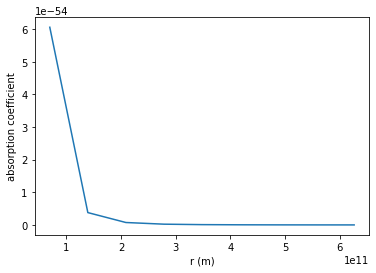

In [169]:
#plot a alpha_nu - r diagram
import matplotlib.pyplot as plt

r_list = [(x*R_sun) for x in range(1, 10)]
alpha_nu_list = [abs_coeff_r(T, nu, n_0, y) for y in r_list]
#print(alpha_nu_list)

#just to check the shape of the function
a_r = plt.subplot()
a_r.plot(r_list, alpha_nu_list)
a_r.set_xlabel("r (m)")
a_r.set_ylabel("absorption coefficient")
plt.show()

The absorption coefficient (AC) was derived using the density profile which decreases as r^-2. While calculating the AC, I used astropy units to see the resulting units of the AC. However, I'm not sure if these are the right units as I have left the Gaunt factor to be dimensionless (the code doesn't compute the log of a dimensionful variable). 

The plot makes sense as r^-4, but plots for any r really as I don't know what values the AC should be/is expected to be. 

In [170]:
def opt_depth(d):
    """calculate the optical depth given a radius from which the absorption coefficient is obtained.
    d = distance to absorption, from observer
    """
    #take 20 steps, for instance
    #taking d to be up to the position of the planet
    dr = d/20
    dr_array = np.arange(1, d, dr)
    tau_nu = 0

    # for each dr, calculate and add up d\tau at the r+dr position
    for r in dr_array:
        #print(r)
        alpha_nu = abs_coeff_r(T, nu, n_0, r)
        tau_nu += alpha_nu*dr
    
    return tau_nu

The method I use in calculating the optical depth (OD) is by summing all the contributions from each new r + dr times the AC at that r.

In [171]:
example_OD = opt_depth(pc)
print(example_OD)

21921174.088152245


In [172]:
# constant in cgs units
au = 1.49597871 * (10**13) # cm

#2D grid
L_grid = 100
wind_coordinate_system = np.linspace((-0.03*au, -0.03*au), (0.03*au, 0.03*au), L_grid) # axes of x & y, this is not a 2d grid!

# here we fill the grid with the corresponding number density at position (x,y)
# now using numpy meshgrid, was originally two for loops which is very inefficient
x, y = np.meshgrid(wind_coordinate_system[:, 0], wind_coordinate_system[:, 1], indexing='ij')
r = (x**2 + y**2)**0.5 # 2d grid with r vector

# calculate the density profile which goes as r^-2
n = n_0 * r**(-2) # 2d grid with number density profile


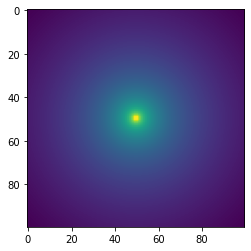

In [173]:
from matplotlib.colors import LogNorm

#log normalized plot of a slice of the wind
plt.imshow(n, norm=LogNorm())

Above, I have made a 2D grid of coordinates x & y. The center of the wind is taken as the origin of the grid. This grid took inspiration from the right figure in fig. 2 in Kavanagh et al. (2020). The density profile is calculated using n = n_0 * r^-2 and r is simply the direct distance from the origin to point (x,y). I might make a color diagram to see if the density profile is symmetrically (and thus correctly) distributed from the origin over the grid.

Here is the important part: r in the number density is taken as a radius with origin of the wind. d in the optical depth is the distance where the observer's position is the origin. This distance d is defined along the line of sight which is what we use to determine the OD of this grid in the following note/block.

In [174]:
# more convenient absorption coefficient
# took the (for now) constants inside the functions
def alpha_r(r):
    """Calculate the absorption coefficient with only r dependence, 
    holding T, nu & n_0 at constant example values.
    """
    T = 10**6  # K
    nu = 10 ** 8 # Hz = 100 MHz
    n_0 = 10**8  # cm^-3

    C = 3.692 * (10**8)
    BB = 1 - np.exp(-(h * nu) / (k_B * T))
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )
    return (C * BB * g * (n_0**2)) / (np.sqrt(T) * (nu**3) * 4 * (r**4))

In [175]:
# trying integration by summing over d\tau contributions
x1 = R_sun
x2 = 0.03*au
N = 100
D = x2-x1
tau = 0
dx = D/N

for i in range(N):
    xi = ((i+1)/100)* D + x1
    #if xi == 0:
    #    print(f"found zero x at i = {i}")
    alpha = alpha_r(xi)
    tau+= alpha*dx

print(tau)

1.2889259272914173e-43


In [176]:
import scipy.integrate as integrate
# trying scipy integration functions: quad

test = integrate.quad(lambda x: alpha_r(x), R_sun, 0.03*au)
print(test)

(1.399495222279737e-43, 1.3102110347624868e-46)


using my own summation method of integation gives a result comparable to scipy.integrate function. Note that the result is only half the desired integrated length throughout the line of sight, since it runs from R_sun to 0.03AU. But this is the case for both integration methods. This is to avoid division by zero.
My question now is why the result is such a small number, is this normal?

Next I am gonna try the integrate.trapezoid integration as discussed during the meeting on monday (170624). I have to figure out it works first.

In [177]:
# trying trapezoid integral
ix = wind_coordinate_system[:,0]
iy = alpha_r(ix)
trapezoid_integral = integrate.trapezoid(iy, x=ix)
print(trapezoid_integral)

6.190090779208355e-39


In [178]:
# trying with observer as origin, with the star at a distance 1 pc
ix = pc + wind_coordinate_system[:,0]
iy = alpha_r(ix)
tau_los = integrate.trapezoid(iy, x=ix) #along line of sight
print(tau_los)

1.4067526591418841e-72


The AC repends on r, which has its origin at the stars location. The OD has its origin at the distant observer, so we need some method to change r to x along the line of sight. 

In [179]:
# converting r to x (line of sight)
ix = wind_coordinate_system[:,0] # x-axis
y_height = wind_coordinate_system[-1, 1] # top value on y-axis
ir = (ix**2 + y_height**2)**0.5
iy = alpha_r(ir)
tau_top = integrate.trapezoid(iy, x=ix)
print(tau_top)

2.0203631700517068e-45


In [180]:
tau = []

for y_height in wind_coordinate_system[:,1]: # for every value on the y-axis        
    ir = (ix**2 + y_height**2)**0.5
    iy = alpha_r(ir)

    # integrate to find the optical depth "per y-layer"
    tau_max = integrate.trapezoid(iy, x=ix)
    tau.append(tau_max)

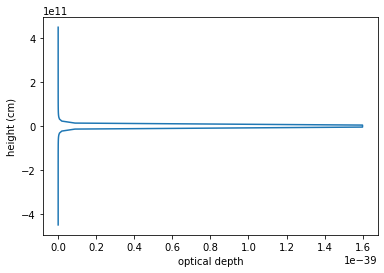

In [181]:
# plot to see if the OD values per y-layer make sense
plt.plot(tau, ix)
plt.ylabel("height (cm)")
plt.xlabel("optical depth")
plt.show()

This plot is incorrect, as the absorption within and behind the star do not contribute to the optical depth. In the next blocks, I will take this into account. 

In [182]:
# using x and y values to also determine wether a position is indide or behind the star
def alpha_xy(x,y):
    """Calculate the absorption coefficient with only x and y dependence, 
    holding T, nu & n_0 at constant example values.
    Returns zero if (x,y) is inside or behind the star with R = R_sun
    """
    T = 10**6  # K
    nu = 10 ** 8 # Hz = 100 MHz
    n_0 = 10**8  # cm^-3

    C = 3.692 * (10**8)
    BB = 1 - np.exp(-(h * nu) / (k_B * T))
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )
    r = (x**2 + y**2)**0.5
    if r <= R_sun:  # if position is within the radius of the star, the absorption coefficient is zero
        C=0
    elif np.abs(y) <= R_sun: # additionally rule out positions that are behind the star
        if x > 0:
            C=0
    return (C * BB * g * (n_0**2)) / (np.sqrt(T) * (nu**3) * 4 * (r**4))

In [183]:
tau = []

#using x and y coordinates to exclude position within and behind star
for y_height in wind_coordinate_system[:,1]: # for every value on the y-axis        
    iy = [alpha_xy(x, y_height) for x in ix]

    # integrate to find the optical depth "per y-layer"
    tau_max = integrate.trapezoid(iy, x=ix)
    tau.append(tau_max)

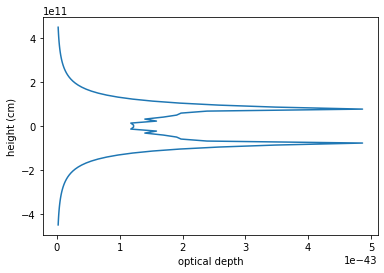

In [184]:
# plot to see if the OD values per y-layer make sense
plt.plot(tau, ix)
plt.ylabel("height (cm)")
plt.xlabel("optical depth")
plt.show()

This plot makes more sense, as the central y-height blocks a lot of space and absorption that we do not observe

In [187]:
# the blackbody term is constant for const T and nu
B = ((2*h*nu**3)/(c**2))*(np.exp((h*nu)/(k_B*T)) - 1)**(-1)
def I_tau(tau_max): # the intensity given a maximum optical depth
    return B*(1 - np.exp(-tau_max))

I = [I_tau(x) for x in tau]

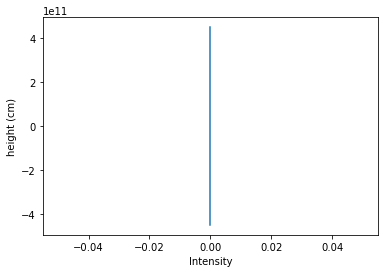

In [188]:
plt.plot(I, ix)
plt.ylabel("height (cm)")
plt.xlabel("Intensity")
plt.show()

This is a problem, probably caused by me not calculating the absoption coefficient correctly. It seems these values are too small and in turn, cause the exponent in the formula for the intensity to result in 1.0.

In [192]:
# attempt to calculate the flux

half_iy = []
half_I = []
for i in L_grid:
    if wind_coordinate_system[i,1] > R_sun:
        half_iy.append(ix[i])
        half_I.append(I[i])

Flux = 2*np.pi*integrate.trapezoid(half_I, x=half_iy)

TypeError: 'int' object is not iterable